# LightGBM + RandomForest + SVM

### Business Background

Customer churn prediction means knowing which customers are likely to leave from bank.

We can see that Exited is our label. We want to predict whether a customer churns or not; CustomerId, Surname, Geography, Gender, HasCrCard, IsActiveMember are categorical variables, and the rest are numerical variables.

Methods: The churn rate is predicted by using the LightGBM, RandomForest and SVM.

Significance:  Acquiring new customers often costs more than retaining existing ones.

If a customers may churn, firm should make with each customer to maximize their likelihood of staying.

Impact of customer churn on businesses: A company with a high churn rate loses many customers, resulting in lower growth rates and a greater impact on sales and profits. Companies with low churn rates can retain customers.

In [1]:
import sys
sys.path.append('/Users/owenwei/opt/anaconda3/lib/python3.9/site-packages/')
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import lightgbm as lgb
from sklearn.tree import export_graphviz
import pydot
import graphviz

from sklearn.svm import SVC

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


### EDA

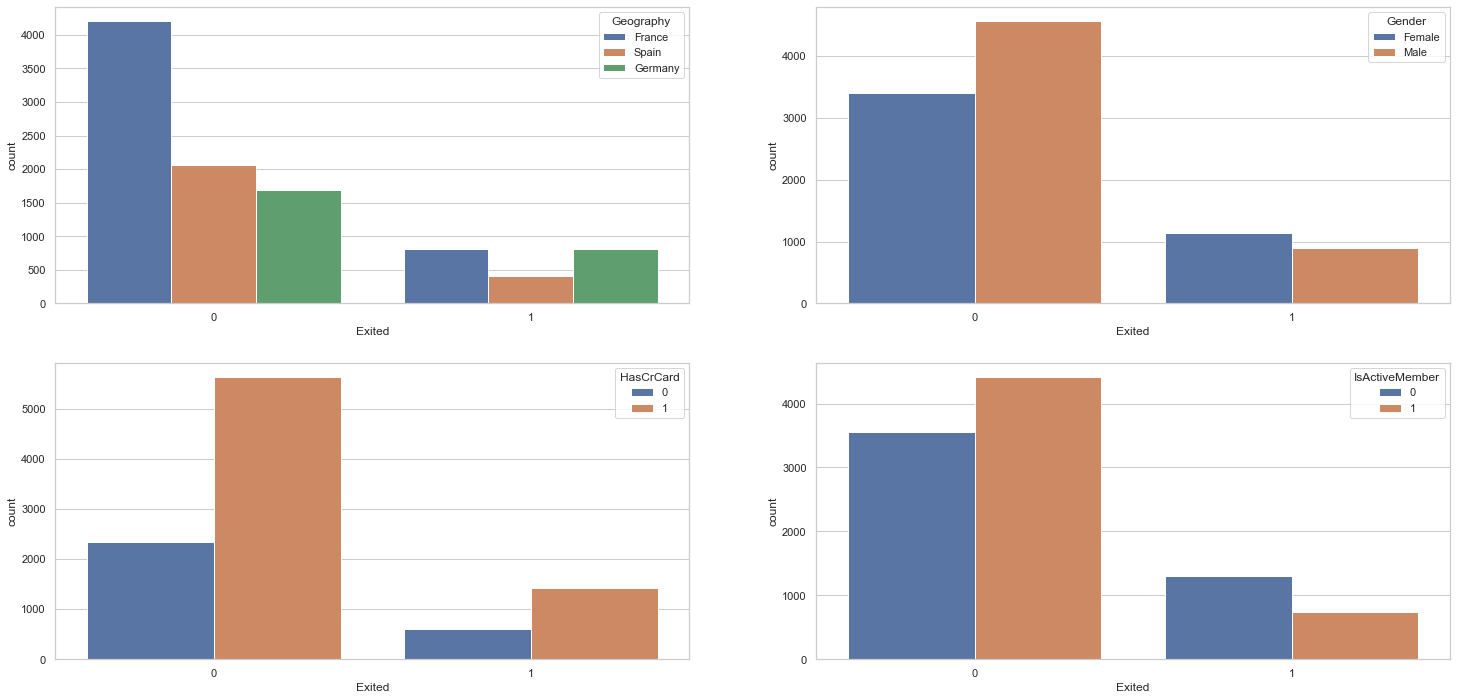

In [3]:
# Distribution of categorical variables with respect to Exited
_,ax1 = plt.subplots(2,2, figsize=[25,12])
cur_row = 0
cur_col = 0
for col in ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']:
    sns.countplot(x='Exited', hue=col, data=df, ax=ax1[cur_row][cur_col])
    cur_col += 1
    if cur_col == 2:
        cur_row += 1
        cur_col = 0

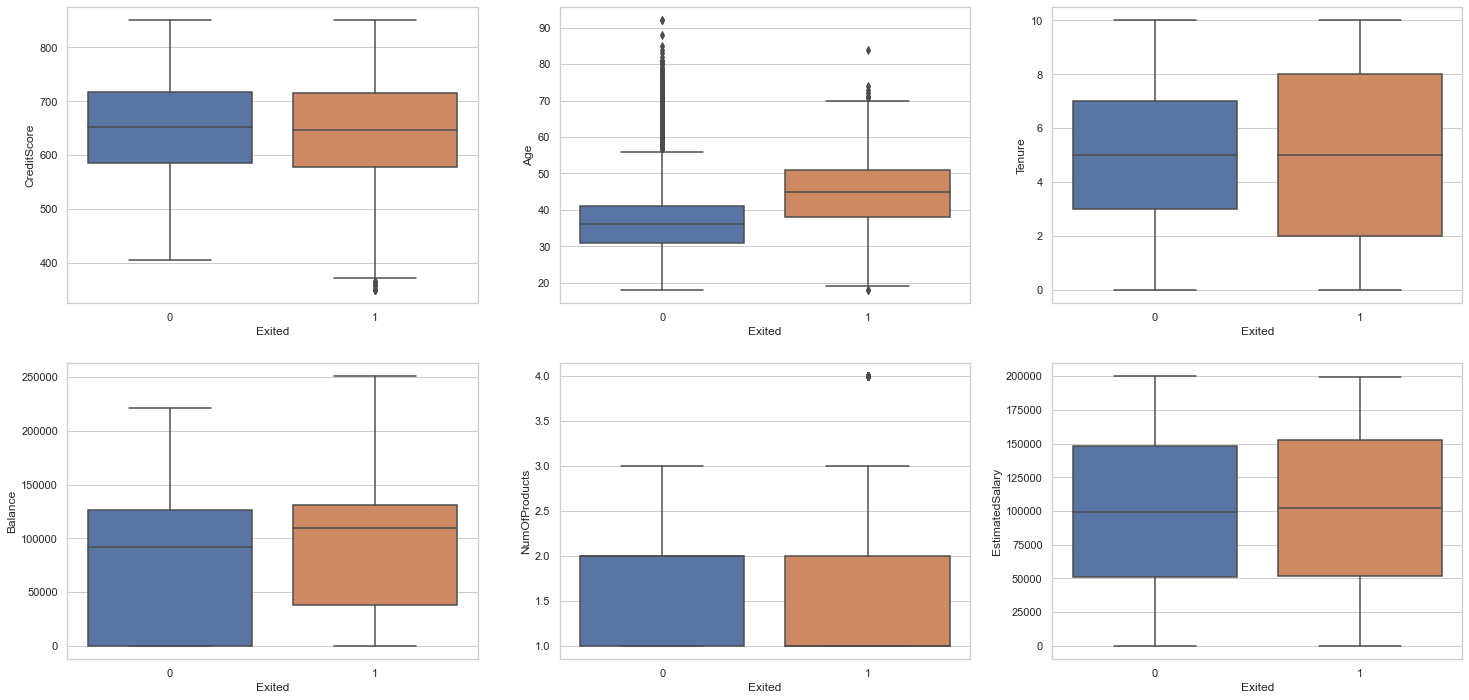

In [4]:
#Boxplots of numerical variables with respect to Exited
num_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
_,ax1 = plt.subplots(2,3, figsize=[25,12])
cur_row = 0
cur_col = 0
for col in num_cols:
    sns.boxplot(x='Exited', y=col, data=df, ax=ax1[cur_row][cur_col])
    cur_col += 1
    if cur_col == 3:
        cur_row += 1
        cur_col = 0

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Churn')

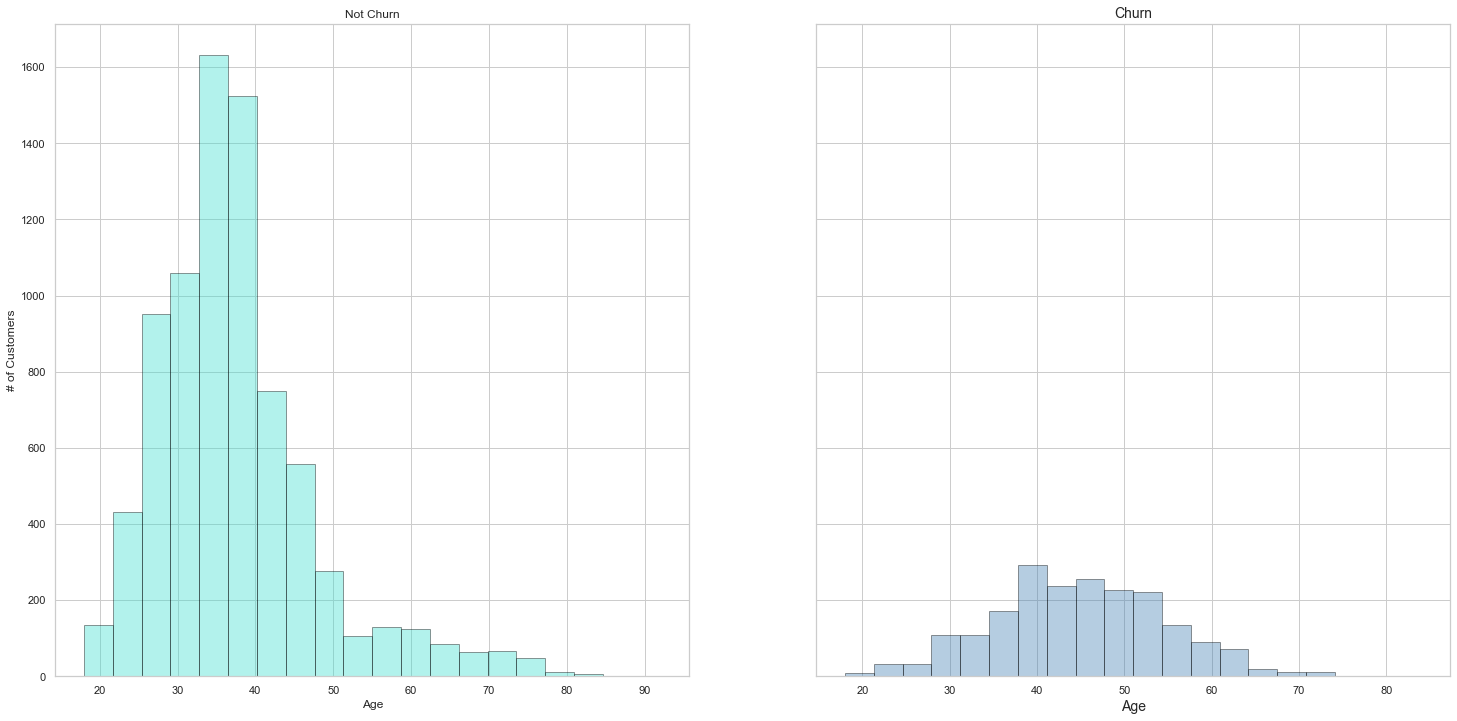

In [5]:
#Let's check the distribution of Age for churned and non-churned people.
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey = True, figsize = [25,12])

ax = sns.distplot(df[df['Exited'] == 0]['Age'],
                   hist=True, kde=False,
                   bins=20, color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Age')
ax.set_title('Not Churn')

ax = sns.distplot(df[df['Exited'] == 1]['Age'],
                   hist=True, kde=False,
                   bins=20, color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Age',size = 14)
ax.set_title('Churn',size = 14)

In [6]:
#check duplicated data
print(len(df['CustomerId'].unique()))

#drop null value
df.dropna()

# drop the Name
df = df.drop(columns = ['RowNumber','CustomerId','Surname'])

#transfer Sex to 0 as female and 1 as male
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

10000


In [7]:
def oneHotEncode(df,colNames):
    """
    Returns a pandas dataframe after only transfering categorical feature to oneHotEncode
    
    Parameters
    ----------
    df: dataframe
    colNames: the column names of dataframe
    """
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            #get_dummies to apply One-Hot Encode
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)
            
            # drop the encoded column
            df.drop([col],axis = 1,inplace=True)
    return df

In [8]:
df = oneHotEncode(df,['Geography'])

In [9]:
df.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.501400,0.250900,0.247700
std,96.653299,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.500023,0.433553,0.431698
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.000000,0.000000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,1.000000,0.000000
max,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [10]:
df.corr()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
CreditScore,1.000000,-0.002857,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,-0.008928,0.005538,0.004780
Gender,-0.002857,1.000000,-0.027544,0.014733,0.012087,-0.021859,0.005766,0.022544,-0.008112,-0.106512,0.006772,-0.024628,0.016889
Age,-0.003965,-0.027544,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,-0.039208,0.046897,-0.001685
Tenure,0.000842,0.014733,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,-0.002848,-0.000567,0.003868
Balance,0.006268,0.012087,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,-0.231329,0.401110,-0.134892
NumOfProducts,0.012238,-0.021859,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,0.001230,-0.010419,0.009039
HasCrCard,-0.005458,0.005766,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.002467,0.010577,-0.013480
IsActiveMember,0.025651,0.022544,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,0.003317,-0.020486,0.016732
EstimatedSalary,-0.001384,-0.008112,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.003332,0.010297,-0.006482
Exited,-0.027094,-0.106512,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,-0.104955,0.173488,-0.052667


In [11]:
def eda_histgoram(df, features):
    for feature in features:
        plt.title(feature)
        plt.hist(df[feature], 
            color = 'blue', 
            edgecolor = 'black',
            bins = 100)
        plt.show()

In [12]:
def plot_hist(df):
    # Get list of column names
    columns = df.columns.tolist()

    # Loop through columns and plot histogram for each
    for col in columns:
        plt.hist(df[col])
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

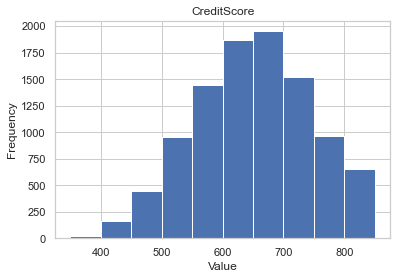

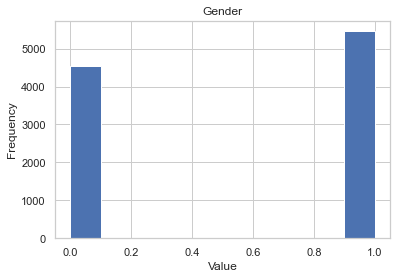

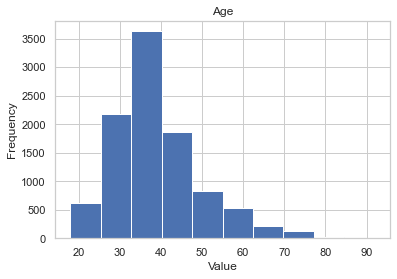

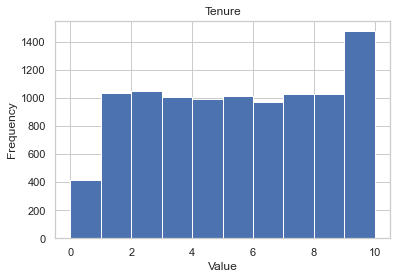

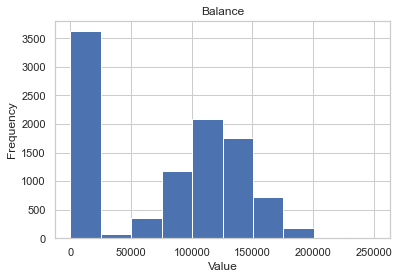

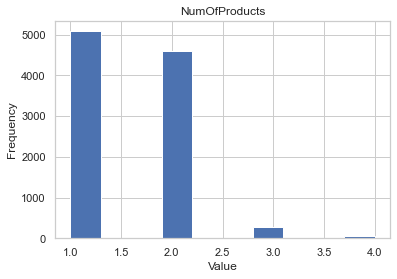

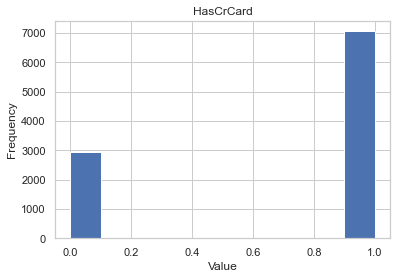

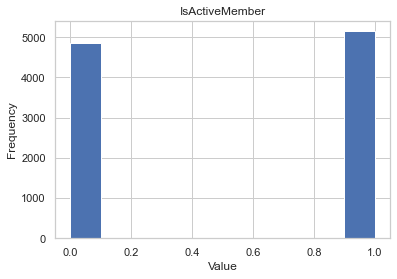

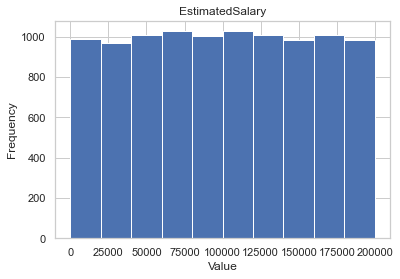

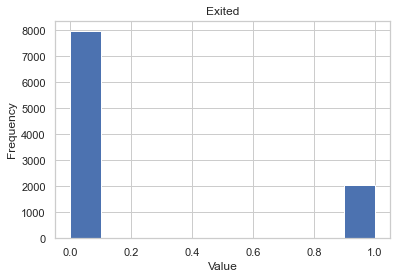

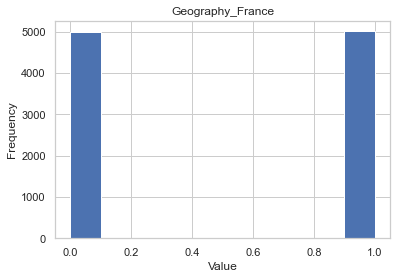

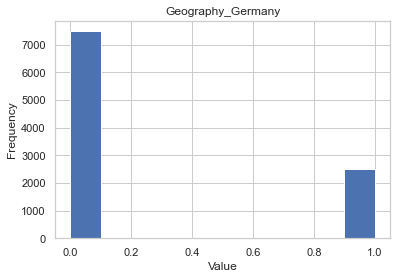

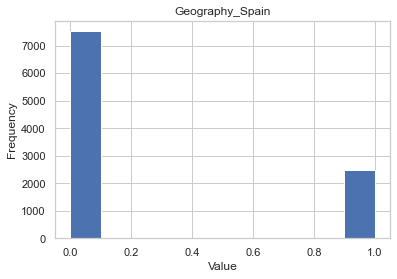

In [13]:
plot_hist(df)

### Split the train and test data

In [14]:
# Extract the target column using pop()
Y = df.pop('Exited')
# Extract the feature columns (i.e., all columns except 'Target') using drop()
X = df

In [15]:
## we simply separate the dataset to 70% dataset as train dataset and 30% dataset test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

(array([5584.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1416.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

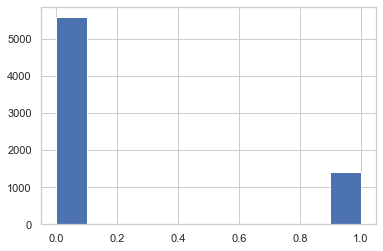

In [16]:
# Check the balance of the train data
plt.hist(Y_train)

#### SMOTE algorithm (Synthetic Minority Oversampling Technique)
Balancing the labeling 0 and 1 in dataset

In [17]:
os = SMOTE(random_state=0)
X_2 = X_train
Y_2 = Y_train

In [18]:
columns = X_2.columns
os_data_X_2, os_data_Y_2 = os.fit_resample(X_2, Y_2)
os_data_X_2 = pd.DataFrame(data=os_data_X_2,columns=columns )
os_data_Y_2 = pd.DataFrame(data=os_data_Y_2,columns=['Exited'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X_2))
print("Number of 0 in oversampled data",len(os_data_Y_2[os_data_Y_2['Exited']==0]))
print("Number of 1 in oversampled data",len(os_data_Y_2[os_data_Y_2['Exited']==1]))
print("Proportion of 0 in oversampled data is ",len(os_data_Y_2[os_data_Y_2['Exited']==0])/len(os_data_X_2))
print("Proportion of 1 in oversampled data is ",len(os_data_Y_2[os_data_Y_2['Exited']==1])/len(os_data_X_2))

length of oversampled data is  11168
Number of 0 in oversampled data 5584
Number of 1 in oversampled data 5584
Proportion of 0 in oversampled data is  0.5
Proportion of 1 in oversampled data is  0.5


In [19]:
X_train = os_data_X_2
Y_train = os_data_Y_2

(array([5584.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5584.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

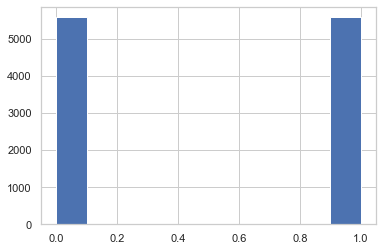

In [20]:
# Check the balance of the train data
plt.hist(Y_train)

### Apply GridSearchCV to find the best hyperparameters

In [21]:
# Define parameter grid
param_grid = {
    'num_leaves': [30, 50, 100],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.2],
}

In [22]:
# Create LightGBM model
lgb_model = lgb.LGBMClassifier()

# Define GridSearchCV object
grid_search = GridSearchCV(lgb_model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train)

# Print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

Best parameters: {'learning_rate': 0.2, 'max_depth': 15, 'num_leaves': 100}
Best score: 0.8860210298761837


/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Run the LightGBM Model

In [23]:
best = grid_search.best_params_
clf = lgb.LGBMClassifier(**best, random_state=88)
clf.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(learning_rate=0.2, max_depth=15, num_leaves=100, random_state=88)

In [24]:
# predict the results
Y_pred=clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

### Model Performance

In [25]:
accuracy=accuracy_score(Y_pred, Y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(Y_test, Y_pred)))

LightGBM Model accuracy score: 0.8373


In [26]:
cm = confusion_matrix(Y_test, Y_pred)
print(cm)
print(classification_report(Y_test, Y_pred))

[[2137  242]
 [ 246  375]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2379
           1       0.61      0.60      0.61       621

    accuracy                           0.84      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.84      0.84      0.84      3000



<AxesSubplot:>

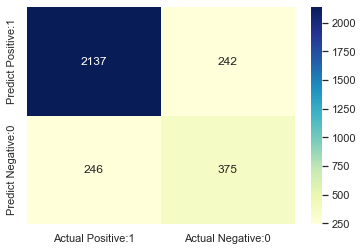

In [27]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

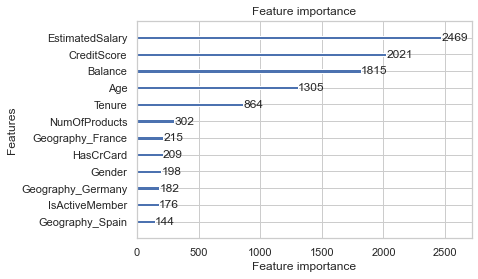

In [28]:
lgb.plot_importance(clf)

In [29]:
def plotProbabilityDistribution(Y_pred,Y_test):
    df_matrix = pd.DataFrame()
    df_matrix["test"] = Y_test
    df_matrix["predict"] = Y_pred
    
    plt.figure(figsize=(16,10))
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlabel("Confidence Level", fontsize = 20)
    
    plt.hist(df_matrix['predict'],
         color = 'blue',
         edgecolor = 'black',
         bins = 100,)
    
    return df_matrix

,test,predict
9394,0,0.856584
898,1,0.274683
2398,0,0.016728
5906,0,0.007157
2343,0,0.000475
...,...,...
4004,0,0.005898
7375,0,0.001033
9307,0,0.003614
8394,0,0.000477


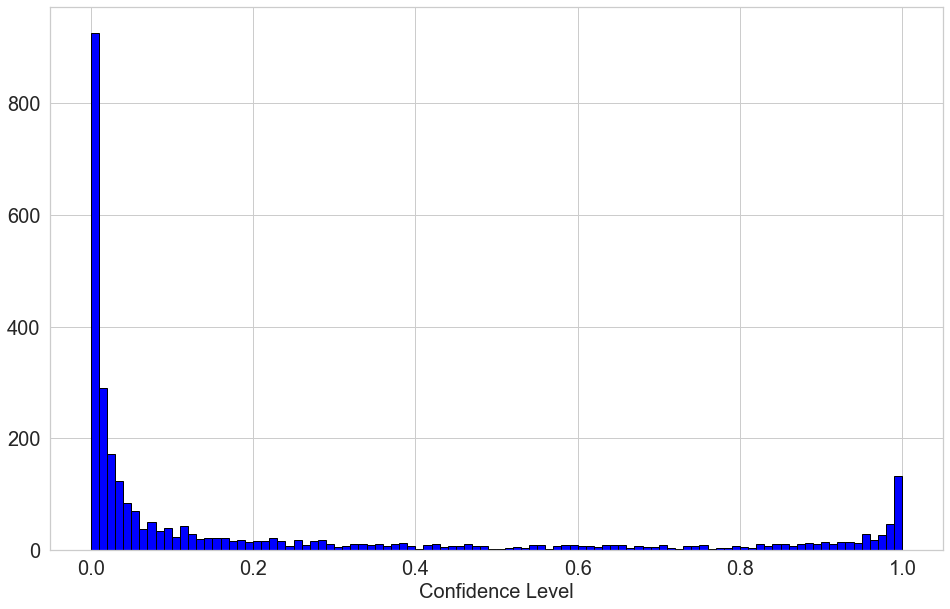

In [30]:
plotProbabilityDistribution(y_pred_prob,Y_test)

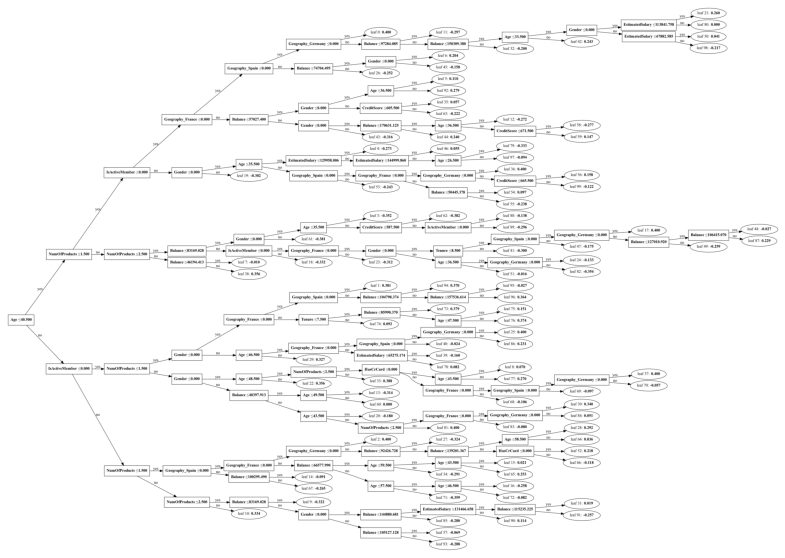

In [31]:
# Plot the decision tree
lgb.plot_tree(clf, figsize=(20, 10))
plt.show()

### Optimization in threshold by G-Mean

In [32]:
# Based on G-Mean to find the best threshold
def rocPlotAndBestThreshold(Y_test, Y_pred, y_pred_prob):    
    auc = roc_auc_score(Y_test, Y_pred)
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
    
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    plt.figure(figsize=(16,10)) #change your figure size as per your desire here
    plt.plot(fpr, tpr, label='(AUC = %0.3f)' % auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')

    plt.show()
    
    return thresholds[ix]

Best Threshold=0.190978, G-Mean=0.777


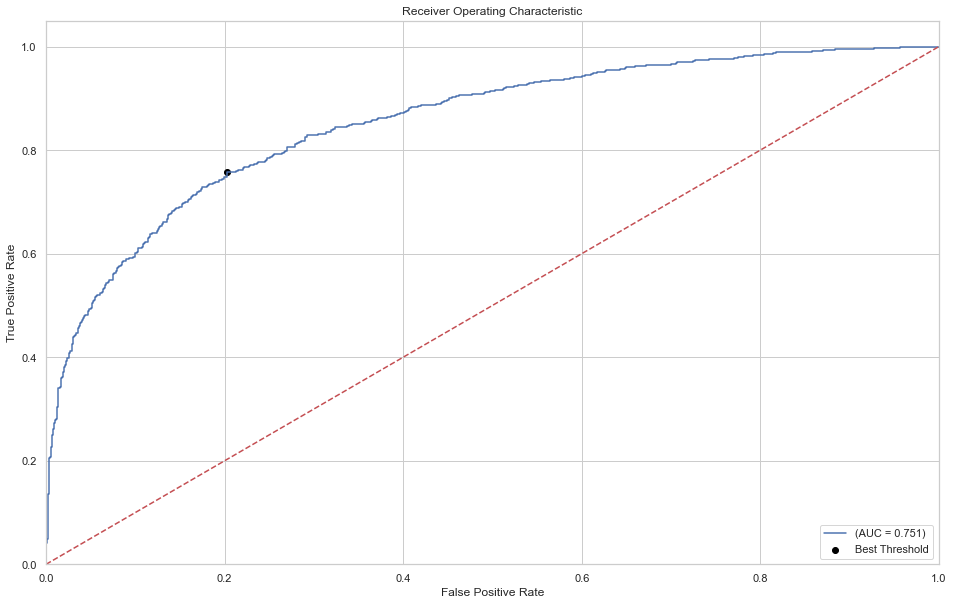

In [33]:
threshold = rocPlotAndBestThreshold(Y_test,Y_pred,y_pred_prob)

In [34]:
# the function to change the thresholds
def probs_to_prediction(probs, threshold):
    pred=[]
    for x in probs:
        if x>threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred

In [35]:
Y_pred_GMEAN = probs_to_prediction(y_pred_prob, threshold)

In [36]:
cm_GMEAN = confusion_matrix(Y_test, Y_pred_GMEAN)
print(cm_GMEAN)
print(classification_report(Y_test, Y_pred_GMEAN))

[[1897  482]
 [ 152  469]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2379
           1       0.49      0.76      0.60       621

    accuracy                           0.79      3000
   macro avg       0.71      0.78      0.73      3000
weighted avg       0.84      0.79      0.80      3000



In [37]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

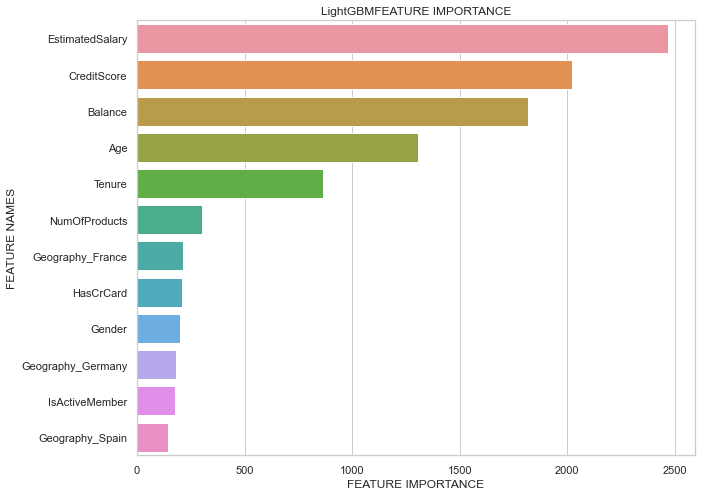

In [38]:
plot_feature_importance(clf.feature_importances_,X_train.columns,'LightGBM')

### Run the RandomForest Model

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

rf_model.fit(X_train, Y_train)
rf_model.predict(X_test)
print("accuracy score is:")
rf_model.score(X_test, Y_test)

/var/folders/mn/g_27w4214xqgf96fjfd220hr0000gn/T/ipykernel_85486/2531487319.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, Y_train)


accuracy score is:


0.8326666666666667

In [40]:
parameters = {
    'n_estimators' : range(40, 180, 20),
    'max_depth': [1,5,10,15,20]
}
gridsearch_rf = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
gridsearch_rf.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y wa

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10, 15, 20],
                         'n_estimators': range(40, 180, 20)})

In [41]:
gridsearch_rf.best_score_

0.8761721006743078

In [42]:
best_para = gridsearch_rf.best_params_
rf_best = RandomForestClassifier(**best_para)
rf_best.fit(X_train, Y_train)

/var/folders/mn/g_27w4214xqgf96fjfd220hr0000gn/T/ipykernel_85486/2343595073.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_best.fit(X_train, Y_train)


RandomForestClassifier(max_depth=20, n_estimators=160)

In [43]:
# predict the results
Y_pred=rf_best.predict(X_test)
y_pred_prob = rf_best.predict_proba(X_test)[:,1]

In [44]:
importances = rf_best.feature_importances_

# Print the importance scores for each feature
for i, score in enumerate(importances):
    print(f"Feature {i}: importance score = {score:.3f}")

Feature 0: importance score = 0.099
Feature 1: importance score = 0.061
Feature 2: importance score = 0.207
Feature 3: importance score = 0.064
Feature 4: importance score = 0.111
Feature 5: importance score = 0.097
Feature 6: importance score = 0.019
Feature 7: importance score = 0.094
Feature 8: importance score = 0.108
Feature 9: importance score = 0.065
Feature 10: importance score = 0.029
Feature 11: importance score = 0.049


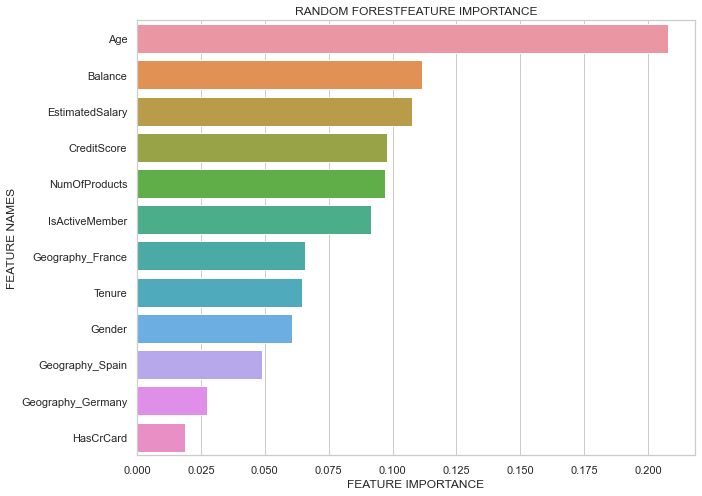

In [45]:
plot_feature_importance(rf_model.feature_importances_,X_train.columns,'RANDOM FOREST')

In [46]:
cm_rf = confusion_matrix(Y_test, Y_pred)
print(cm_rf)
print(classification_report(Y_test, Y_pred))

[[2127  252]
 [ 237  384]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2379
           1       0.60      0.62      0.61       621

    accuracy                           0.84      3000
   macro avg       0.75      0.76      0.75      3000
weighted avg       0.84      0.84      0.84      3000



<AxesSubplot:>

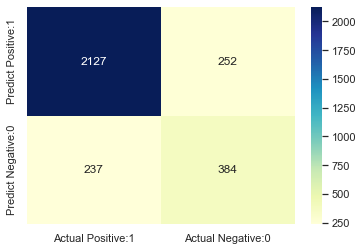

In [47]:
cm_matrix = pd.DataFrame(data=cm_rf, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Best Threshold=0.350000, G-Mean=0.779


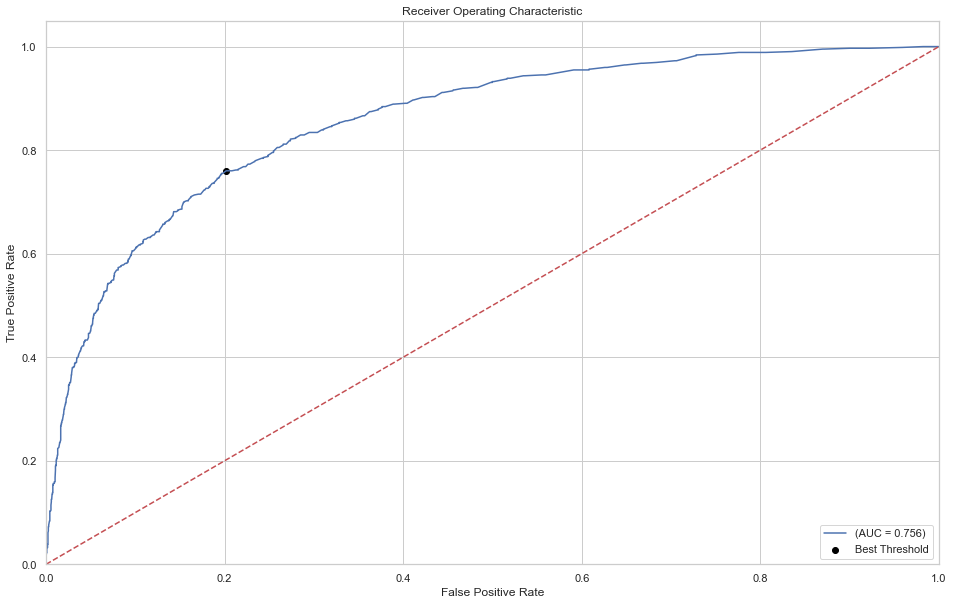

In [48]:
threshold = rocPlotAndBestThreshold(Y_test,Y_pred,y_pred_prob)

In [49]:
Y_pred_GMEAN = probs_to_prediction(y_pred_prob, threshold)

In [50]:
cm_GMEAN = confusion_matrix(Y_test, Y_pred_GMEAN)
print(cm_GMEAN)
print(classification_report(Y_test, Y_pred_GMEAN))

[[1908  471]
 [ 152  469]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2379
           1       0.50      0.76      0.60       621

    accuracy                           0.79      3000
   macro avg       0.71      0.78      0.73      3000
weighted avg       0.84      0.79      0.81      3000



### Run the SVM Model

In [51]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

In [52]:
grid = GridSearchCV(SVC(),param_grid)
grid.fit(X_train,Y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [53]:
print(grid.best_params_)
print(grid.score(X_test,Y_test))

{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.7326666666666667


In [54]:
best_params = grid.best_params_
svm_clf = SVC(**best_params, probability=True)
svm_clf.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, gamma=0.0001, probability=True)

In [55]:
# predict the results
Y_pred = svm_clf.predict(X_test)
y_pred_prob = svm_clf.predict_proba(X_test)[:,1]

In [56]:
cm3 = confusion_matrix(Y_test, Y_pred)
print(cm3)
print(classification_report(Y_test, Y_pred))

[[2152  227]
 [ 575   46]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      2379
           1       0.17      0.07      0.10       621

    accuracy                           0.73      3000
   macro avg       0.48      0.49      0.47      3000
weighted avg       0.66      0.73      0.69      3000



<AxesSubplot:>

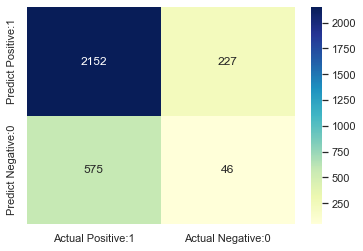

In [57]:
cm_matrix = pd.DataFrame(data=cm3, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Best Threshold=0.479332, G-Mean=0.518


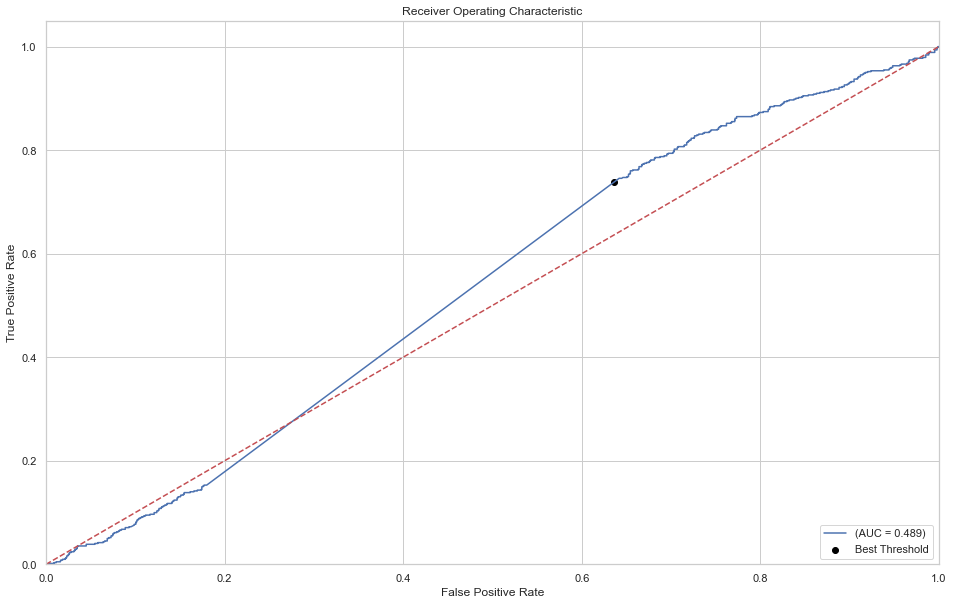

In [58]:
threshold = rocPlotAndBestThreshold(Y_test, Y_pred, y_pred_prob)

In [59]:
Y_pred_SVM = probs_to_prediction(y_pred_prob, threshold)

In [60]:
cm_GMEAN = confusion_matrix(Y_test, Y_pred_GMEAN)
print(cm_GMEAN)
print(classification_report(Y_test, Y_pred_GMEAN))

[[1908  471]
 [ 152  469]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2379
           1       0.50      0.76      0.60       621

    accuracy                           0.79      3000
   macro avg       0.71      0.78      0.73      3000
weighted avg       0.84      0.79      0.81      3000

